In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image, ImageDraw
from utils import custom_dataset
from torch.functional import F
from model import custom_model
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pathlib, os

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Variáveis

In [2]:
IMG_SIZE = 150
N_GRIDS = 5

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1., -1., -1), std=(2., 2., 2.)),
    transforms.ToPILImage()
])

def collate_function(batch):
    
    imgs_tensor, bbox_tensor, target_tensor = [], [], []
    
    for annotations, img_path in batch:
        for annotation in annotations:
            img_pil, p_obj, bbox_obj, bbox_cell, target = annotation
            imgs_tensor.append(transformer(img_pil))
            bbox_tensor.append(bbox_obj)
            target_tensor.append(target)
    
    imgs_tensor = torch.stack(imgs_tensor)
    bbox_tensor = torch.tensor(bbox_tensor, dtype=torch.float)
    target_tensor = torch.tensor(target_tensor, dtype=torch.long)

    return imgs_tensor, bbox_tensor, target_tensor

# Criando modelo e realizando teste

imgs_tensor.shape=torch.Size([64, 3, 30, 30])
output.shape=torch.Size([64, 7])
loss=tensor(1.3961, grad_fn=<AddBackward0>)


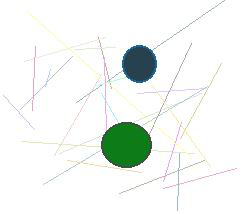

In [3]:
df = pd.read_csv('annotations.csv')
dataset = custom_dataset(df, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_function)
imgs_tensor, bbox_tensor, target_tensor = next(iter(dataloader))

print (f'{imgs_tensor.shape=}')

model = custom_model(imgs_tensor, 3, IMG_SIZE, N_GRIDS, transformer, inv_transformer)
output = model(imgs_tensor)
print (f'{output.shape=}')
loss = model.calculate_loss(output, bbox_tensor, target_tensor)
loss.backward()
print (f'{loss=}')

img_pil = Image.open('./imgs/img00001.jpg')
deteccoes = model.detect(img_pil, threshold=0.2)

draw = ImageDraw.Draw(img_pil)
for bbox, classe, prob in deteccoes:
    cor = {0: 'red', 1: 'green'}
    draw.rectangle(bbox, fill=None, width=2, outline=cor[classe])

img_pil

# Preparando variáveis e funções úteis

In [4]:
IMG_SIZE = 150
N_GRIDS = 5
BATCH_SIZE = 32

df = pd.read_csv('annotations.csv')
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['tipo'])

df_train = pd.DataFrame(df_train.values, columns=df.columns) # se não fizer essas duas linhas o dataloader não funciona
df_test = pd.DataFrame(df_test.values, columns=df.columns) # se não fizer essas duas linhas o dataloader não funciona

print (f'{df.shape=}, {df_train.shape=}, {df_test.shape=}')

train_dataset = custom_dataset(df_train, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)
test_dataset = custom_dataset(df_test, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_function)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_function)

print (f'{len(train_dataloader)=}, {len(test_dataloader)=}')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'{device=}')

model = custom_model(imgs_tensor, num_classes=3, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS, transformer_=transformer, inv_transformer_=inv_transformer)
model.to(device)
print (f'Criando modelo e jogando para device.')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print (f'Criando otimizador.')

def validate(dataloader_):
    model.eval()
    test_loss, n = 0, 0
    print ('Validação: ')
    with torch.no_grad():
        for imgs_tensor, bbox_tensor, target_tensor in tqdm(dataloader_):
            imgs_tensor, bbox_tensor, target_tensor = imgs_tensor.to(device), bbox_tensor.to(device), target_tensor.to(device)
            output = model(imgs_tensor)
            loss = model.calculate_loss(output, bbox_tensor, target_tensor)
            test_loss += loss.item()
            n += len(imgs_tensor)
    
    return test_loss/n

def deteccao_aleatoria(threshold=0.3):
    img_pil = Image.open(df_test.sample(1)['img_path'].values[0])

    deteccoes = model.detect(img_pil, threshold=threshold, device=device)

    draw = ImageDraw.Draw(img_pil)
    for bbox, classe, prob in deteccoes:
        cor = {0: 'red', 1: 'green'}
        draw.rectangle(bbox, fill=None, width=2, outline=cor[classe])
        x0, y0 = bbox[0], bbox[1]
        draw.text((x0, y0-10), f'{str(classe)},{str(round(prob*100))}%', fill=cor[classe])

    plt.figure(figsize=(10, 4))
    plt.title(f'{threshold=}')
    plt.imshow(img_pil)
    plt.show()

def limpar_diretorio_log(log_dir):
    docs_list = list(pathlib.Path(log_dir).glob('*'))
    for doc in docs_list:
        try:
            os.remove(str(doc))
        except:
            print (f'{str(doc)} não pode ser excluído.')

#test_loss = validate(test_dataloader)
#print (f'Exemplo de resultado da função perda {test_loss=}')

log_dir = './logs/treinamento-01'
limpar_diretorio_log(log_dir)
writer = SummaryWriter(log_dir=log_dir)
print (f'Preparando pasta para logs. {log_dir=}')

df.shape=(60000, 8), df_train.shape=(54000, 8), df_test.shape=(6000, 8)
len(train_dataloader)=1688, len(test_dataloader)=188
device=device(type='cuda', index=0)
Criando modelo e jogando para device.
Criando otimizador.
Preparando pasta para logs. log_dir='./logs/treinamento-01'


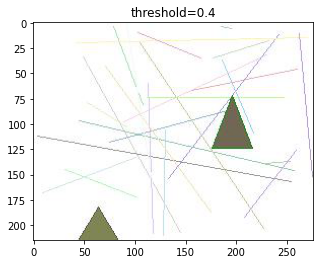

In [5]:
deteccao_aleatoria(threshold=0.4)

# Treinamento

epoch=9


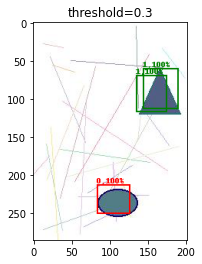

100%|██████████| 1688/1688 [02:34<00:00, 10.91it/s]


Validação: 


100%|██████████| 188/188 [00:15<00:00, 12.06it/s]

Fim treinamento.


In [6]:
for epoch in range(10):
    
    model.train()
    clear_output(wait=True)
    print (f'{epoch=}')
    deteccao_aleatoria()

    with torch.set_grad_enabled(True):
        train_loss, n = 0, 0
        for imgs_tensor, bbox_tensor, target_tensor in tqdm(train_dataloader):
            imgs_tensor, bbox_tensor, target_tensor = imgs_tensor.to(device), bbox_tensor.to(device), target_tensor.to(device)

            model.zero_grad()
            output = model(imgs_tensor)
            loss = model.calculate_loss(output, bbox_tensor, target_tensor)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            n += len(imgs_tensor)
    
    test_loss = validate(test_dataloader)
    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('test_loss', test_loss, epoch)

print (f'Fim treinamento.')

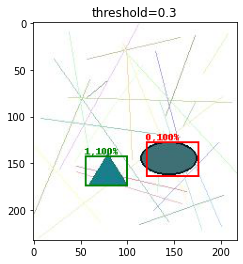

In [7]:
deteccao_aleatoria()

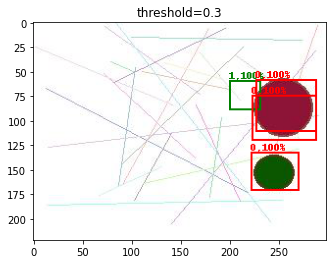

In [8]:
deteccao_aleatoria()

In [9]:
checkpoint = {
    'state_dict': model.state_dict(),
    
}
torch.save(checkpoint, f'checkpoint.pth')